In [ ]:
# requirements
# !pip install astropy
# !pip install matplotlib

In [1]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

# import desired cosmology
# from prospect.sources.constants import cosmo # WMAP9
from astropy.cosmology import WMAP7 as cosmo

# for converstion between time and redshift
from astropy.cosmology import z_at_value 
import astropy.units as u 

# save time by pickling results to avoid repeating long computations
import pickle

In [2]:
# import prospector, see https://github.com/bd-j/prospector
# note the requirements for prospector must also be installed
import prospect
print( prospect.__version__ )

1.2.1.dev30+g2fa085d


In [3]:
# details of cosmology
cosmo

FlatLambdaCDM(name="WMAP7", H0=70.4 km / (Mpc s), Om0=0.272, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.0455)

# define time of observation and agebins


In [4]:
zobs = 0.8

tuniv = cosmo.age(zobs).value

In [5]:
def build_agebins( zobs, tlims_first = [1e-9,0.03,0.1,0.3,1], ftmax=0.95, nbins=10, log_spacing=True ):

    tuniv = cosmo.age(zobs).value
    tbinmax = ftmax * tuniv

    agelims = tlims_first[:-1]
    if log_spacing:
        agelims += np.logspace( np.log10(tlims_first[-1]), np.log10(tbinmax), nbins-len(tlims_first)+1 ).tolist()

        # equivalent to
        # agelims_first = np.log10( tlims_first ) + 9
        # agelims = agelims_first[:-1] 
        # agelim_max = np.log10( tbinmax )+9
        # agelims += np.linspace( agelims_first[-1], agelim_max, nbins-len(agelims_first)+1 ).tolist()
        # agelims += [np.log10( tuniv )+9]
    else:
        agelims += np.linspace( tlims_first[-1], tbinmax, nbins-len(tlims_first)+1 ).tolist()
        
    agelims += [tuniv]
    
    # convert to units of log(t/yr)
    agelims = np.log10( np.array(agelims) * 1e9)
    # convert from list of bin edges to to array of bins
    agebins = np.array([agelims[:-1], agelims[1:]])
    agebins = agebins.T

    return agebins

nbins = 10


In [6]:
# agebins which are logarithmically spaced (for those not explictly specified)

agebins_logs = build_agebins( zobs, log_spacing=True, nbins=nbins )
agebins_logs_Gyr = 10**(agebins_logs-9)


agebins_logs_Gyr

array([[1.00000000e-09, 3.00000000e-02],
       [3.00000000e-02, 1.00000000e-01],
       [1.00000000e-01, 3.00000000e-01],
       [3.00000000e-01, 1.00000000e+00],
       [1.00000000e+00, 1.45549047e+00],
       [1.45549047e+00, 2.11845250e+00],
       [2.11845250e+00, 3.08338742e+00],
       [3.08338742e+00, 4.48784100e+00],
       [4.48784100e+00, 6.53200980e+00],
       [6.53200980e+00, 6.87579979e+00]])

In [7]:
# agebins which are linearlly spaced (for those not explictly specified)

agebins_lins = build_agebins( zobs, log_spacing=False, nbins=nbins )
agebins_lins_Gyr = 10**(agebins_lins-9)

agebins_lins_Gyr

array([[1.00000000e-09, 3.00000000e-02],
       [3.00000000e-02, 1.00000000e-01],
       [1.00000000e-01, 3.00000000e-01],
       [3.00000000e-01, 1.00000000e+00],
       [1.00000000e+00, 2.10640196e+00],
       [2.10640196e+00, 3.21280392e+00],
       [3.21280392e+00, 4.31920588e+00],
       [4.31920588e+00, 5.42560784e+00],
       [5.42560784e+00, 6.53200980e+00],
       [6.53200980e+00, 6.87579979e+00]])

In [8]:
#  the difference 

agebins_lins_Gyr - agebins_logs_Gyr

array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.65091149],
       [0.65091149, 1.09435142],
       [1.09435142, 1.23581846],
       [1.23581846, 0.93776684],
       [0.93776684, 0.        ],
       [0.        , 0.        ]])

# define parameters of interest

In [9]:
# for plotting

par_params = dict( 
                   mwa=dict(label=r'$t_\mathrm{age}$',  bounds=[0,tuniv] ),
                   t80mt20=dict(label=r'$t_{80}-t_{20} = \tau_\mathrm{SF}$',  bounds=[0,6] ), 
                   z_form=dict(label=r'$z_\mathrm{form} = z(t_\mathrm{univ} - t_mathrm{age})$',  bounds=[0,10] ),
                 )


# define priors

In [10]:
# number of draws from the priors
size = int(1e4)

from prospect.models import priors

### define Continuity prior

In [11]:
def prior_continuity( agebins, mu=0, scale=0.3, df=2,
                      size=int(1e5),
                      **extras ):
    from prospect.models.transforms import logsfr_ratios_to_sfrs

    """
    The continuity prior controls the relative log SFR between adjacent time
     bins via a distribution. By default a StudentT distribution
     with mean=0, scale=0.3, degrees freedom=2.
    which Leja+2020 showed to reproduce the diversity of SFHs from Illustris TNG at z=0
    This will be referred to as the "Constant SFH Continuity prior"
    """ 

    # parameters have dimension nbins-1
    nbins = agebins.shape[0]

    mean = np.full( nbins-1, mu )
    scale = np.full( nbins-1, scale )
    df = np.full( nbins-1, df )

    prior_logsfr_ratios =  priors.StudentT( mean=mean, scale=scale, df=df )

    # sample from the prior
    # prior_logsfr_ratios.sample( nsample=1 )
    #  note that the variable nsample is actually not used by this function
    #  so the function only returns one draw at a time

    # to get many draws, loop 
    logsfr_ratios_rvs = np.stack([ prior_logsfr_ratios.sample() 
                                for i in range(size) ])

    # alternatively, use the scipy distribution
    #  much faster
    # logsfr_ratios_rvs = prior_logsfr_ratios.distribution( 
    #                                   loc=prior_logsfr_ratios.loc, 
    #                                   scale=prior_logsfr_ratios.scale, 
    #                                   *prior_logsfr_ratios.args,  ).rvs( (size, nbins-1) )

    # convert logsfr_ratios to SFRs

    ssfrs_rvs = np.stack([ logsfr_ratios_to_sfrs( logmass=0, logsfr_ratios=logsfr_ratios_i, agebins=agebins )
                            for logsfr_ratios_i in logsfr_ratios_rvs ])

    return dict( ssfrs=ssfrs_rvs )


### define Dirichlet prior

In [12]:

def prior_dirichlet( agebins, alphaD, size=int(1e5), **extras ):
    """ 
    The Dirichlet prior sets the probability of the fractional SFR distributed
    across the time bins via the concentration parameter alphaD
    alphaD > 1: prefers equal distribution
    alphaD < 1: prefers unequal distribution
    """ 
    
    from prospect.models.transforms import zfrac_to_sfr

    nbins = agebins.shape[0]

    # note that sampling from the Dirichlet distribution is done via transformations
    # using Beta distributions
    # See Prospector documentation
    beta = np.full( nbins-1, alphaD)
    alpha = np.cumsum( beta )[::-1]
    mini, maxi = 0.,1.
    prior_zfractions = priors.Beta(alpha=1.0, beta=1.0, mini=0.0, maxi=1.0)

    # to get many draws, loop 
    # z_fractions_rvs = np.stack([ prior_zfractions.sample() 
    #                             for i in range(size) ]).T
    # this fails because only 1 (not nbins-1) samples are given when calling prior_zfractions.sample()

    # do manually
    # see prospect.models.priors.Priors.sample
    z_fractions_rvs = prior_zfractions.distribution.rvs(
                                            *prior_zfractions.args, 
                                            size=(size, nbins-1),
                                            loc=prior_zfractions.loc, 
                                            scale=prior_zfractions.scale)
    
    ssfrs_rvs = np.stack([ zfrac_to_sfr( total_mass=1, z_fraction=z_fractions_i, agebins=agebins )
                           for z_fractions_i in z_fractions_rvs ])

    return dict( ssfrs=ssfrs_rvs )
    

In [13]:
# test
# prior_dirichlet( agebins=agebins_logs, size=size, alphaD = 1, sfh=3  )

### Define latent parameters

In [14]:
def sfr_to_mwa(agebins, sfrs, **extras):
    """
    t_mw = ( int_0^t_obs t SFR(t) dt ) / ( int_0^t_obs SFR(t) dt)

    consistent results to prospect.plotting.sfh.nonpar_mwa
    https://github.com/bd-j/prospector/blob/main/prospect/plotting/sfh.py#L206

    """
    if sfrs is None: return None

    agebins_Gyr = np.power(10., agebins) *1e-9 # Gyr
    mts = np.median(agebins_Gyr, axis=1)
    dts = np.diff(agebins_Gyr)[:,0]
    if sfrs.ndim>1:
        t_mws = np.sum( sfrs * mts * dts, axis=1) / np.sum(  sfrs * dts, axis=1)
    else:
        t_mws = np.sum( sfrs * mts * dts ) / np.sum(  sfrs * dts )
    return t_mws
    
def sfr_to_tquantiles(agebins=None, sfrs=None, q=[0.2,0.5,0.8,0.9], **extras):
    
    from prospect.plotting.sfh import sfh_to_cmf
    cmfs_tvec, cmfs = sfh_to_cmf( sfrs, agebins )

    t_q = np.stack([ np.interp(q, cmf[::-1], cmfs_tvec[::-1] )
                     for cmf in cmfs ])
    
    returnables = {}
    for iqq,qq in enumerate( q ):
        returnables['t{:.0f}'.format( qq*100 )] = t_q[:,iqq]

    return returnables


def average_ssfr_nonparametric( masses=None, sfrs=None, agebins=None, t1=0, t2=0.1, sfh=3 ):
    assert sfh in [3], "Error: only for non-parametric SFHs"

    dt_Gyr = t2 - t1
    dt_yr = dt_Gyr*1e9 # in yr

    ages = 10**( agebins - 9) # Gyr
    # fractional coverage of the bin by the sfr period
    # ft = np.clip((dt_Gyr - ages[:, 0]) / (ages[:, 1] - ages[:, 0]), 0., 1)
    ft2 = np.clip((t2 - ages[:, 0]) / (ages[:, 1] - ages[:, 0]), 0., 1)
    ft1 = np.clip((t1 - ages[:, 0]) / (ages[:, 1] - ages[:, 0]), 0., 1)
    ft = ft2 - ft1

    if masses is None:
        assert sfrs is not None, "Error: must provide masses or SFRs"

        dt = (10**agebins[:, 1] - 10**agebins[:, 0])
        masses = sfrs * dt

    mformed = (ft * masses).sum(axis=1)
    sfr = mformed / dt_yr
    ssfr = sfr / masses.sum(axis=1)

    return ssfr

In [15]:
    
def calculate_latent_parameters( agebins=None, ssfrs=None, **extras ):

    # average SFR over last 100 Myrs
    ssfr_t100_rvs = average_ssfr_nonparametric( sfrs=ssfrs, agebins=agebins, t2=0.1 )

    # mass weighted age
    mwa_rvs = sfr_to_mwa( agebins=agebins, sfrs=ssfrs )

    returnables = dict( mwa=mwa_rvs,  log_ssfr_100Myr=np.log10( ssfr_t100_rvs ) )

    # time at which `q' percent of mass had been formed
    t_q_dict = sfr_to_tquantiles( agebins=agebins, sfrs=ssfrs, q=[0.2,0.5,0.8,0.9] )
    returnables.update( t_q_dict )

    # time taken to form between 20% and 80% of the stellar mass
    # sometimes used as a proxy for the duration of star formation
    returnables['t80mt20'] = np.abs( returnables['t80'] - returnables['t20'] )

    return returnables

### Draw from priors, calculate latent parameters

In [16]:

priors_logs = {}

priors_logs['csfrcont'] = dict( agebins=agebins_logs, size=size, sfh=3, 
                           label='Constant SFR continuity, agebins N-5 logarithmically spaced' )
priors_logs['csfrcont']['draws'] = prior_continuity( **priors_logs['csfrcont'] )

priors_logs['aD1'] = dict( agebins=agebins_logs, size=size, alphaD = 1, sfh=3, 
                           label='Dirichlet alphaD=0.1, agebins N-5 logarithmically spaced' )
priors_logs['aD1']['draws'] = prior_dirichlet( **priors_logs['aD1'] )

for sfh_key in priors_logs.keys():

    priors_logs[sfh_key]['draws'].update( calculate_latent_parameters( **priors_logs[sfh_key], **priors_logs[sfh_key]['draws']  ) )



priors_lins = {}

priors_lins['csfrcont'] = dict( agebins=agebins_lins, size=size, sfh=3, 
                           label='Constant SFR continuity, agebins N-5 linearlly spaced' )
priors_lins['csfrcont']['draws'] = prior_continuity( **priors_lins['csfrcont'] )

priors_lins['aD1'] = dict( agebins=agebins_lins, size=size, alphaD = 1, sfh=3, 
                           label='Dirichlet alphaD=0.1, agebins N-5 linearlly spaced' )
priors_lins['aD1']['draws'] = prior_dirichlet( **priors_lins['aD1'] )

for sfh_key in priors_lins.keys():

    priors_lins[sfh_key]['draws'].update( calculate_latent_parameters( **priors_lins[sfh_key], **priors_lins[sfh_key]['draws']  ) )


# Plot agebins, 1D 'marginalized' prior distributions

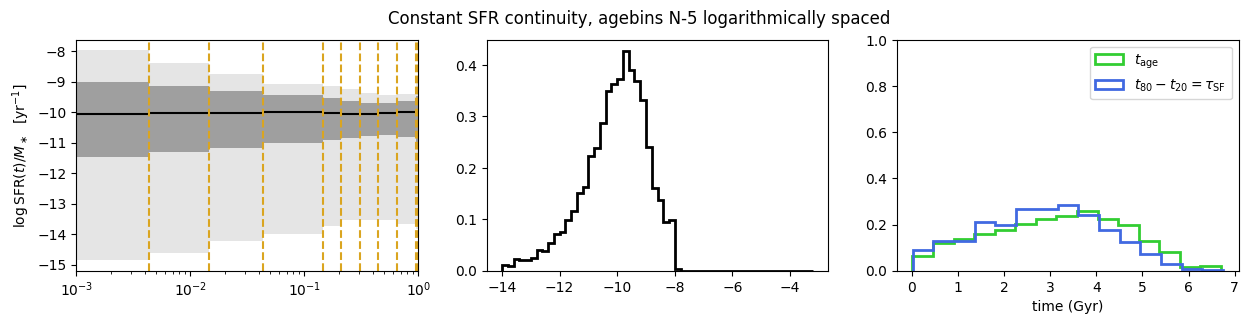

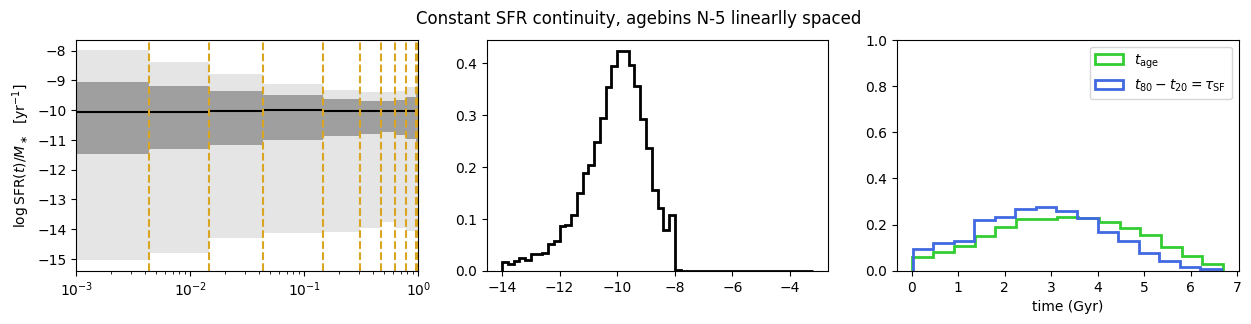

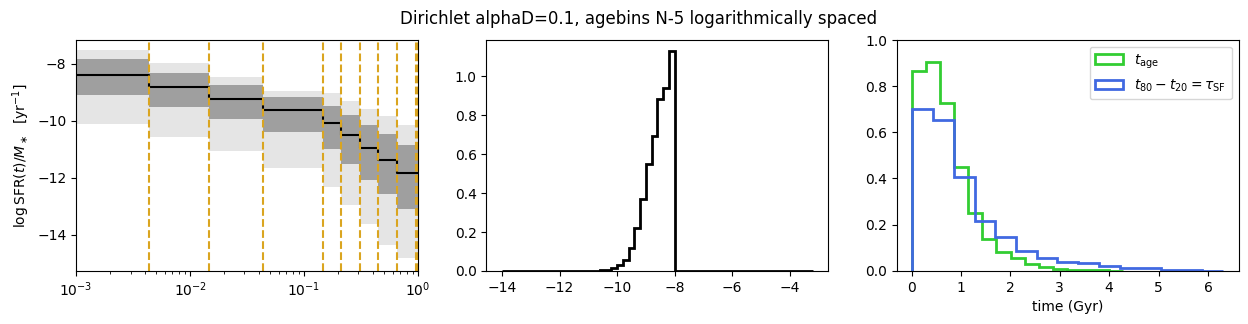

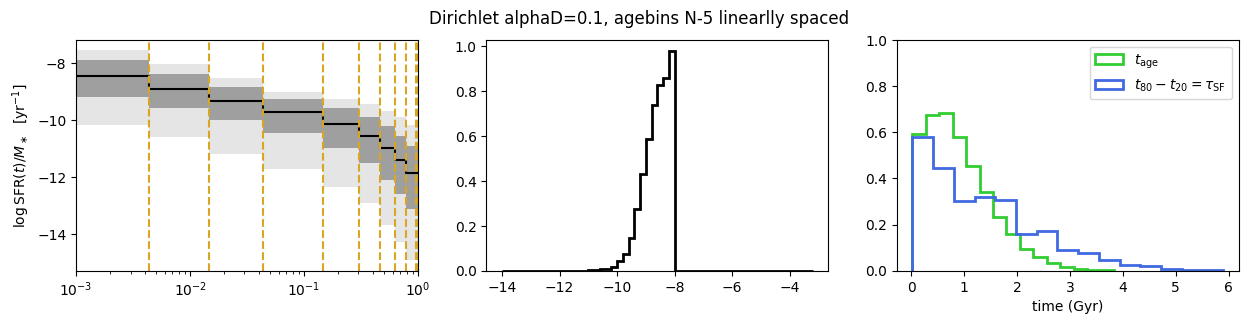

In [19]:
# compare to figure 3 
# https://s3.amazonaws.com/aasie/images/0004-637X/926/2/134/apjac449bf3_hr.jpg

for sfh_key in ['csfrcont','aD1']:

    for sfh_prior in [priors_logs,priors_lins]:

        fig, axes = plt.subplots(1,3, figsize=(5*3, 3) )
        fig.suptitle( sfh_prior[sfh_key]['label'] )
    
        #################

        ssfrs = np.copy( sfh_prior[sfh_key]['draws']['ssfrs'] ) 
        qs_logsfrs = np.log10( np.quantile( ssfrs, axis=0, q=[0.02,0.16,0.5,0.84,0.98]) )

        agebins_Gyr = 10**( sfh_prior[sfh_key]['agebins'] -9 )
        x = agebins_Gyr.flatten() / tuniv
        y02 = np.repeat( qs_logsfrs[0,:], 2 )
        y16 = np.repeat( qs_logsfrs[1,:], 2 )
        y50 = np.repeat( qs_logsfrs[2,:], 2 )
        y84 = np.repeat( qs_logsfrs[3,:], 2 )
        y98 = np.repeat( qs_logsfrs[4,:], 2 )
    
        axes[0].fill_between( x, y02, y98, color='k', alpha=0.1, lw=0 )
        axes[0].fill_between( x, y16, y84, color='k', alpha=0.3, lw=0 )
        axes[0].plot( x, y50, color='k')
    
        for xx in np.unique(x):
            axes[0].axvline(xx, color='goldenrod', ls='--')
        
        # ax.set_yscale('log')
        axes[0].set_ylabel(r'$\log \mathrm{SFR}(t)/M_\ast ~~[\mathrm{yr}^{-1}]$')
        axes[0].set_xscale('log')
        axes[0].set_xlim(1e-3,1)

        #################

        xs = np.copy( sfh_prior[sfh_key]['draws']['log_ssfr_100Myr'] ) 
        axes[1].hist( xs, bins=np.arange(-14,-3,0.2), 
                      density=True, label='log_ssfr_100Myr', 
                     color='k', histtype='step', lw=2 )
        axes[-1].set_xlabel(r'$\log \mathrm{sSFR}_{100} ~~ [\mathrm{yr}^{-1}]$')        

        #################
        
        for i,(par,color) in enumerate( [['mwa','limegreen'],['t80mt20','royalblue']] ):
    
            xs = np.copy( sfh_prior[sfh_key]['draws'][par] ) 
    
            axes[-1].hist( xs, bins=15, density=True, 
                          label=par_params[par]['label'], 
                     color=color, histtype='step', lw=2 ) 
    
        axes[-1].legend()
        axes[-1].set_ylim(0,1)
        axes[-1].set_xlabel('time (Gyr)')        
        
        plt.show()


# Difference between mass-weighted age and t50

In [ ]:
# The mass-weighted age a weighted average is similar to t_50, 
# which is the look-back time when 50% of the stellar mass has been formed 
# and therefore the median age.

sfh_key = 'csfrcont'
sfh_prior = priors_lins

mwa = sfh_prior[sfh_key]['draws']['mwa']
t50 = sfh_prior[sfh_key]['draws']['t50']
print( 1-np.max(np.abs(mwa-t50)/mwa))

# will change if sample size small

# 16% also calculated here to be the largest different between t_50 and t_age

# Calculate z_form, the redshift corresponding to the mass-weighted age

In [22]:
sfh_prior = priors_lins

priors_file = 'priors_z=08.pickle'


In [26]:
# calculate and save, or read
import os

if not os.path.exists( priors_file ):

    for sfh_key in sfh_prior.keys():
        if 'z_form' not in sfh_prior[sfh_key]['draws'].keys():

            lb_times = sfh_prior[sfh_key]['draws']['mwa']
            cosmic_times = ( tuniv - lb_times )* u.Gyr
            sfh_prior[sfh_key]['draws']['z_form'] = z_at_value(cosmo.age, cosmic_times ).value

    # pickle priors dictionary to save time 
    with open(priors_file, 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(sfh_prior, f, pickle.HIGHEST_PROTOCOL)

else:
    # load previously generated prior dictionary

    with open(priors_file, 'rb') as f:
        sfh_prior = pickle.load(f)

    size = sfh_prior['aD1']['size']



# Plot 2d histogram of SFH timescale and mass-weighted age (or z_form)

In [27]:
# setup

import matplotlib as mpl
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', ['1', '0.2'], N=100).with_extremes(over='0', under='1')

from matplotlib.colors import LogNorm
kw_prior_hexbin = dict( gridsize=20,  edgecolors='0.95', linewidths=0.2, norm=LogNorm(vmin=0.99, vmax=size*0.1), cmap=cmap )

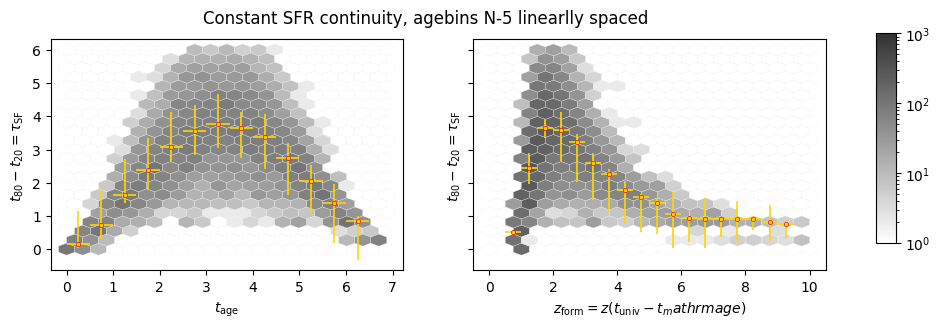

/Users/kawebb/venv_sfhfit/lib/python3.9/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


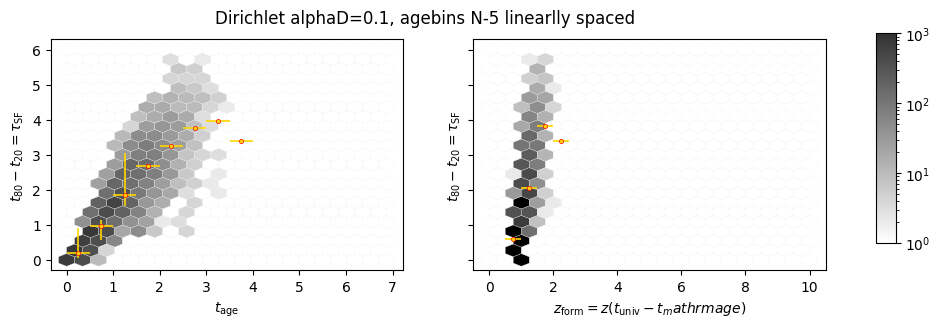

In [28]:
par_y = 't80mt20'

for sfh_key in ['csfrcont','aD1']:

    fig, axes = plt.subplots(1,2, figsize=(5*2, 3), sharey=True )
    fig.suptitle( sfh_prior[sfh_key]['label'] )
    
    for i,par_x in enumerate( ['mwa','z_form'] ):
        pars = [par_x, par_y]
        extent = np.hstack([ par_params[par]['bounds'] for par in pars ])
    
        kw_prior_hexbin['extent'] = extent
    
        xs = np.stack([ np.copy( sfh_prior[sfh_key]['draws'][p] ) 
                        for p in pars ]).T
        
        out = axes[i].hexbin( *xs.T,  **kw_prior_hexbin )
    
        axes[i].set_xlabel( par_params[par_x]['label'] )
        axes[i].set_ylabel( par_params[par_y]['label'] )
        
        # xxs = np.linspace( *extent[:2], nbins_prior_errorbar+1)
        xxs = np.arange( *extent[:2], 0.5)
        nbins_prior_errorbar = len(xxs)-1
        mxxs = xxs[:-1] + np.diff( xxs )/2.
        yys = np.full( (nbins_prior_errorbar,3), np.nan)
        for j in range(nbins_prior_errorbar):
            bin_min, bin_max = xxs[j], xxs[j+1]
            sel = ( bin_min < xs[:,0] ) & ( xs[:,0] <= bin_max )
            if len( xs[sel,1] )>2:
                yys[j,:] = np.quantile( xs[sel,1], q=[0.16,0.5,0.84] )
                
        eyys = np.diff( yys, axis=1 ).reshape(2,-1)
        exxs = np.full_like( mxxs, np.diff( xxs )[0]/2. )
        axes[i].errorbar( mxxs, yys[:,1], yerr=eyys, xerr=exxs, 
                          fmt=' ', color='gold', lw=1.2, 
                          marker='.', mec='r', mew=0.5 )

    plt.colorbar(out, cax=fig.add_axes([0.95,0.2,0.02,0.7]) )
    plt.show()

# Plot 2d histogram of SFH timescale and mass-weighted age (or z_form)

But this time only for the "quiescent" galaxies, following definition of Tacchella+2022


_"From this, one can derive the mass-doubling number $\mathscr{D}$"_

$$
    \mathscr{D}(z) = \mathrm{sSFR}(z) \times t_{\rm H}(z),
$$

_"which is the number of times the stellar mass doubles within the age of the universe at redshift $z$, $t_{\rm H}(z)$, assuming a constant sSFR. Throughout this work, we classify galaxies as star-forming, transitioning, and quiescent if $\mathscr{D}(z)>1/3$, $1/20<\mathscr{D}(z)<1/3$, and $\mathscr{D}(z)<1/20$, respectively. The motivations for these cuts are given in Section~\ref{subsec:sample}. It is important to note that a large fraction of the "green valley" at $z=0$ has $\mathscr{D}<1/20$, indicating that these galaxies can be considered quiescent. This is not the case at earlier cosmic times since the population sSFRs are overall higher relative to the age of the universe."_

In [36]:
def get_mass_doubling( agebins=None, ssfrs=None, **extras ):
  agebins_Gyr = 10**(agebins-9)
  tunivs_Gyr = agebins_Gyr[-1,-1] - agebins_Gyr[:,0]
  tunivs_yr = tunivs_Gyr*1e9

  D = ssfrs * tunivs_yr
  return D


for sfh_key in ['csfrcont','aD1']:

  sfh_prior[sfh_key]['draws']['D'] = get_mass_doubling( agebins=sfh_prior[sfh_key]['agebins'],
                                                        **sfh_prior[sfh_key]['draws'] )


In [37]:

def where_quiescent( D=None, threshold=1/20, **extras ):
  return D < threshold

def where_star_forming( D=None, threshold=1/3, **extras ):
  return D > threshold

def where_green_valley( D=None, threshold_lower=1/20, threshold_upper=1/3, **extras ):
  return ( threshold_lower < D ) & ( D < threshold_upper )

In [38]:
# test that correct identifies regions

sfh_key = 'csfrcont'

x = np.arange( sfh_prior['agebins'].shape[0] )
D = sfh_prior[sfh_key]['draws']['D'][0,:]

plt.plot( x, D, color='k', zorder=-1 )

sel_quescient = where_quiescent( D )
plt.scatter( x[sel_quescient], D[sel_quescient], color='r', label='is Quiescent' )


sel_greenvalley = where_green_valley( D )
plt.scatter( x[sel_greenvalley], D[sel_greenvalley], color='lime', label='is Green valley'  )


sel_starforming = where_star_forming( D )
plt.scatter( x[sel_starforming], D[sel_starforming], color='c', label='is Star forming'  )


plt.axhline(1/3, color='b', label='GV/SF deliminter' )
plt.axhline(1/20, color='r', label='Q/SF deliminter')
plt.yscale('log')
plt.legend()
plt.xlabel('index of agebins')
plt.ylabel('D')
plt.show()

KeyError: 'agebins'

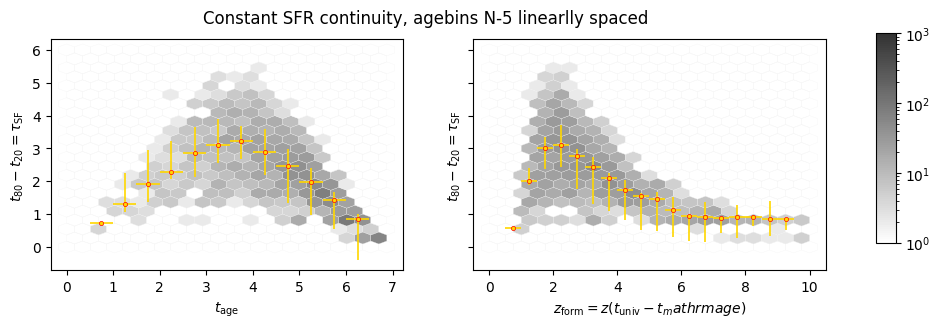

/Users/kawebb/venv_sfhfit/lib/python3.9/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


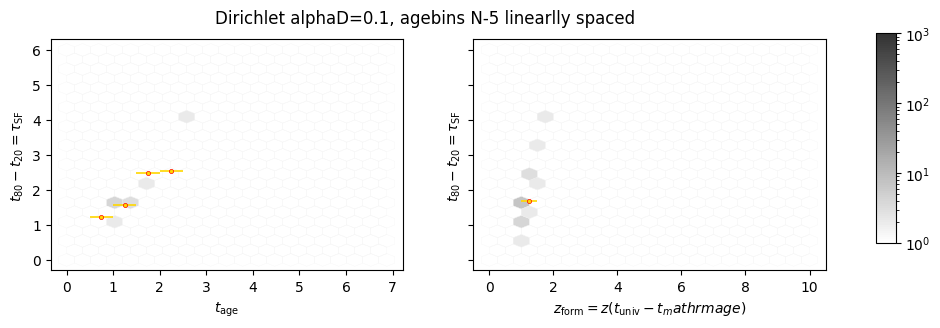

In [39]:
par_y = 't80mt20'

for sfh_key in ['csfrcont','aD1']:

    fig, axes = plt.subplots(1,2, figsize=(5*2, 3), sharey=True )
    fig.suptitle( sfh_prior[sfh_key]['label'] )
    
    for i,par_x in enumerate( ['mwa','z_form'] ):
        pars = [par_x, par_y]
        extent = np.hstack([ par_params[par]['bounds'] for par in pars ])
    
        kw_prior_hexbin['extent'] = extent
    
        xs = np.stack([ np.copy( sfh_prior[sfh_key]['draws'][p] ) 
                        for p in pars ]).T


        sel_quescient = where_quiescent( **sfh_prior[sfh_key]['draws'] )
        sel_quiescent_now = sel_quescient[:,0]
        xs = xs[ sel_quiescent_now, ... ]                        
        
        out = axes[i].hexbin( *xs.T,  **kw_prior_hexbin )
    
        axes[i].set_xlabel( par_params[par_x]['label'] )
        axes[i].set_ylabel( par_params[par_y]['label'] )
        
        # xxs = np.linspace( *extent[:2], nbins_prior_errorbar+1)
        xxs = np.arange( *extent[:2], 0.5)
        nbins_prior_errorbar = len(xxs)-1
        mxxs = xxs[:-1] + np.diff( xxs )/2.
        yys = np.full( (nbins_prior_errorbar,3), np.nan)
        for j in range(nbins_prior_errorbar):
            bin_min, bin_max = xxs[j], xxs[j+1]
            sel = ( bin_min < xs[:,0] ) & ( xs[:,0] <= bin_max )
            if len( xs[sel,1] )>2:
                yys[j,:] = np.quantile( xs[sel,1], q=[0.16,0.5,0.84] )
                
        eyys = np.diff( yys, axis=1 ).reshape(2,-1)
        exxs = np.full_like( mxxs, np.diff( xxs )[0]/2. )
        axes[i].errorbar( mxxs, yys[:,1], yerr=eyys, xerr=exxs, 
                          fmt=' ', color='gold', lw=1.2, 
                          marker='.', mec='r', mew=0.5 )

    plt.colorbar(out, cax=fig.add_axes([0.95,0.2,0.02,0.7]) )
    plt.show()